# Setup

In [1]:
from pathlib import Path
from functools import partial

import numpy as np
import pandas as pd
import scipy.stats as sts

import arviz as av
import seaborn as sns
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import mcx.distributions as dist

# sns.set_style("darkgrid")

# Code 3.1

In [2]:
p_positive_vampire = 0.95
p_positive_mortal  = 0.01
p_vampire = 0.001

p_positive = (
    p_positive_vampire * p_vampire 
    + p_positive_mortal * (1 - p_vampire)
)
p_positive

0.01094

$$
P(V | +) = \frac{P(+ | V) \cdot P(V)}{P(+)}
$$

In [3]:
p_vampire_positive = (
    p_positive_vampire * p_vampire
    / p_positive
)

p_vampire_positive

0.08683729433272395

# Code 3.2

In [4]:
grid_size = 1000

sample = "WLWWWLWLW"
n = len(sample)
k = sample.count("W")

In [5]:
rng_key   = jax.random.PRNGKey(0)

p_grid    = jnp.linspace(0, 1, grid_size)
p_prior   = jnp.ones(grid_size)

binom      = dist.Binomial(n=n, p=p_grid)
likelihood = jnp.exp(binom.logpdf(k))

posterior = p_prior * likelihood
posterior /= posterior.sum()

/home/elantkom/.cache/pypoetry/virtualenvs/rethinking-7skSNelE-py3.8/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


# Code 3.3

In [6]:
samples   = jax.random.choice(
    a=p_grid, 
    p=posterior,
    shape=(10_000, ), 
    key=rng_key, 
)

# Figure 3.1

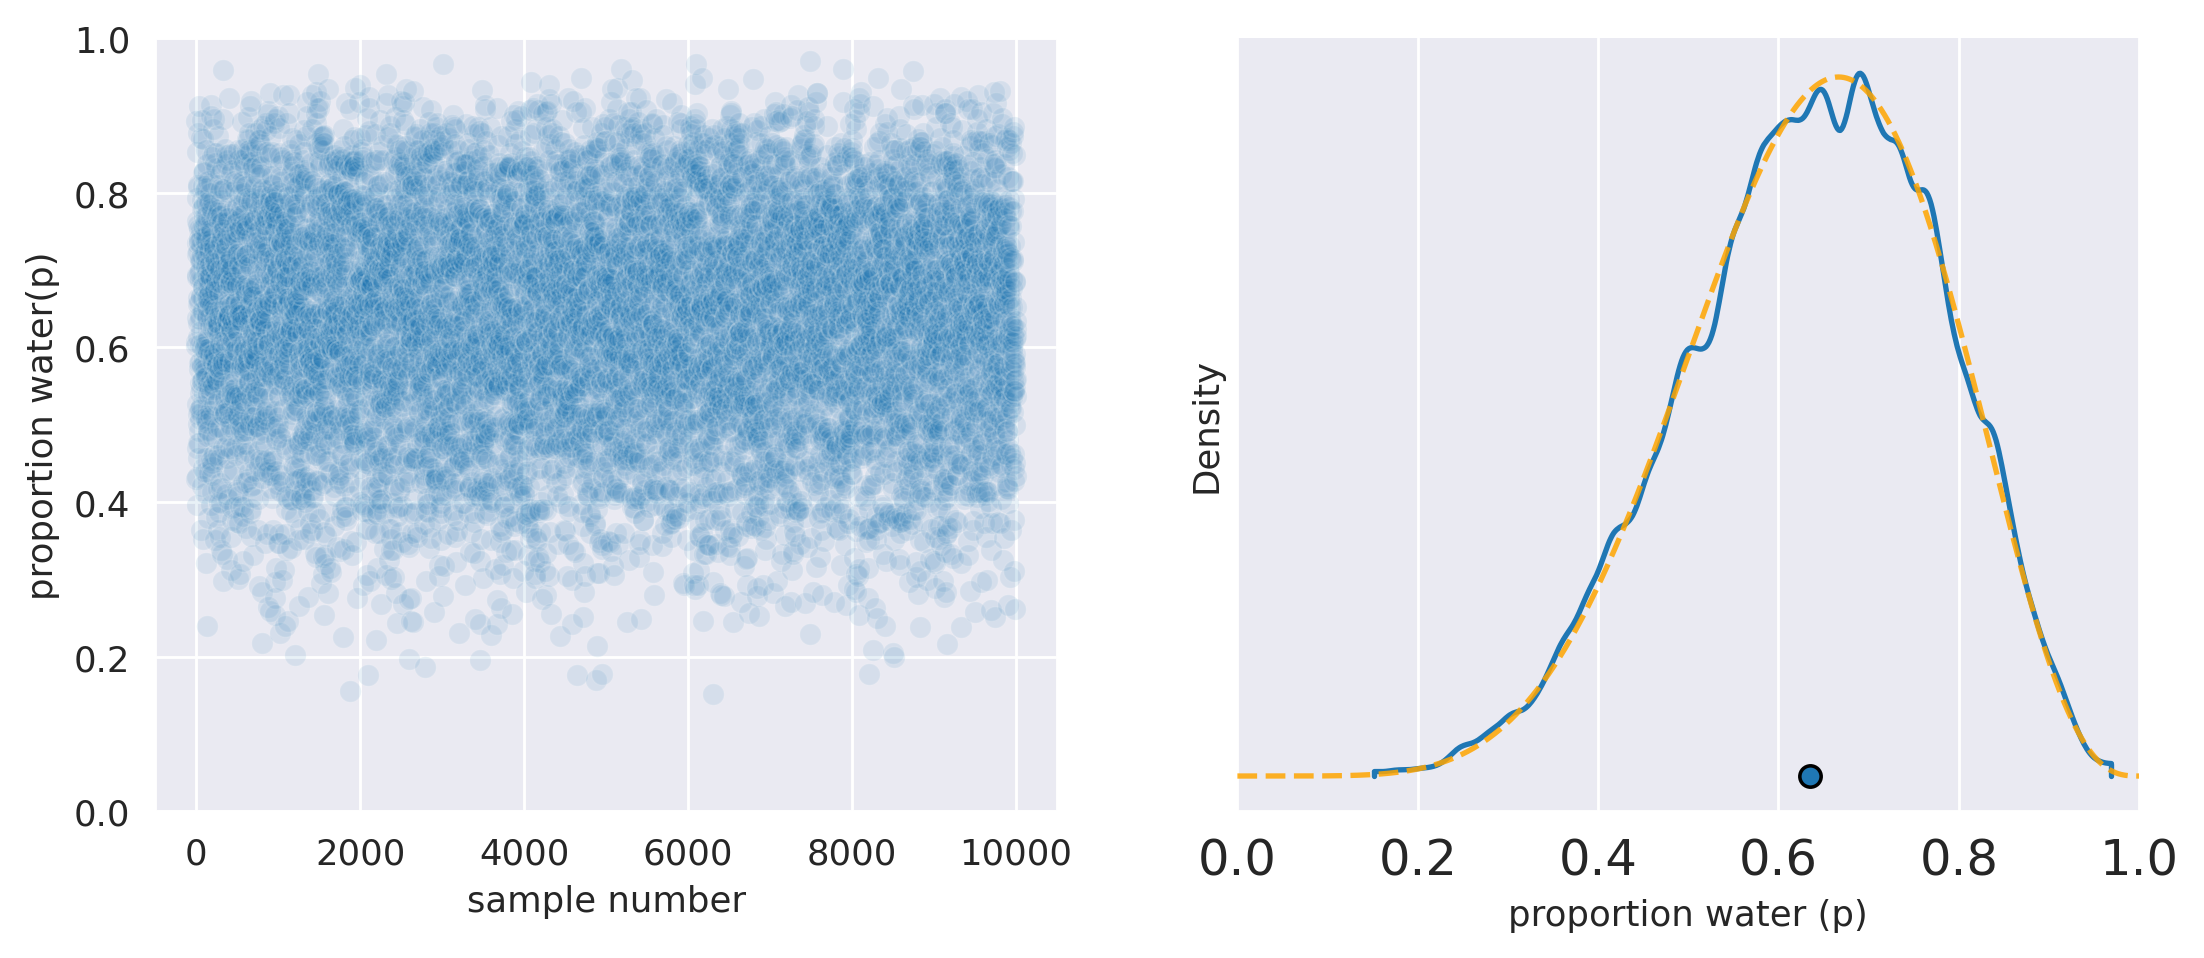

In [7]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(10, 4), dpi=256)

ax0 = sns.scatterplot(x=jnp.arange(10_000), y=samples, alpha=0.1, ax=ax0)
ax0.set_ylim(0., 1.)
ax0.set_ylabel("proportion water(p)")
ax0.set_xlabel("sample number");

ax1 = av.plot_density({"": samples}, hdi_prob=1, ax=ax1)
ax1.set_xlim(0., 1.)
ax1.set_ylabel("Density")
ax1.set_xlabel("proportion water (p)");

# Bonus, not shown in the original figure
ax1 = sns.lineplot(
    x=p_grid, 
    y=posterior * 1e3, 
    alpha=0.85, 
    color="orange", 
    linestyle="--", 
    ax=ax1
)

# Code 3.6

In [8]:
mask = p_grid < 0.5
posterior[mask].sum()

DeviceArray(0.17187457, dtype=float32)

# Code 3.7

In [9]:
(samples < 0.5).mean()

DeviceArray(0.179, dtype=float32)

# Code 3.8

In [10]:
((samples > 0.5) & (samples < 0.75)).mean()

DeviceArray(0.5962, dtype=float32)

# Code 3.9

In [11]:
pd.Series(samples).quantile(0.8)

0.7607607841491699

# Code 3.10

In [12]:
pd.Series(samples).quantile([0.1, 0.9])

0.1    0.442442
0.9    0.813814
dtype: float64

# Figure 3.2

In [13]:
def plot_posterior_interval(p_grid, posterior, mask, ax):
    ax = sns.lineplot(x=p_grid, y=posterior, ax=ax)
    ax.fill_between(p_grid[mask], posterior[mask], alpha=0.5)
    
    return ax

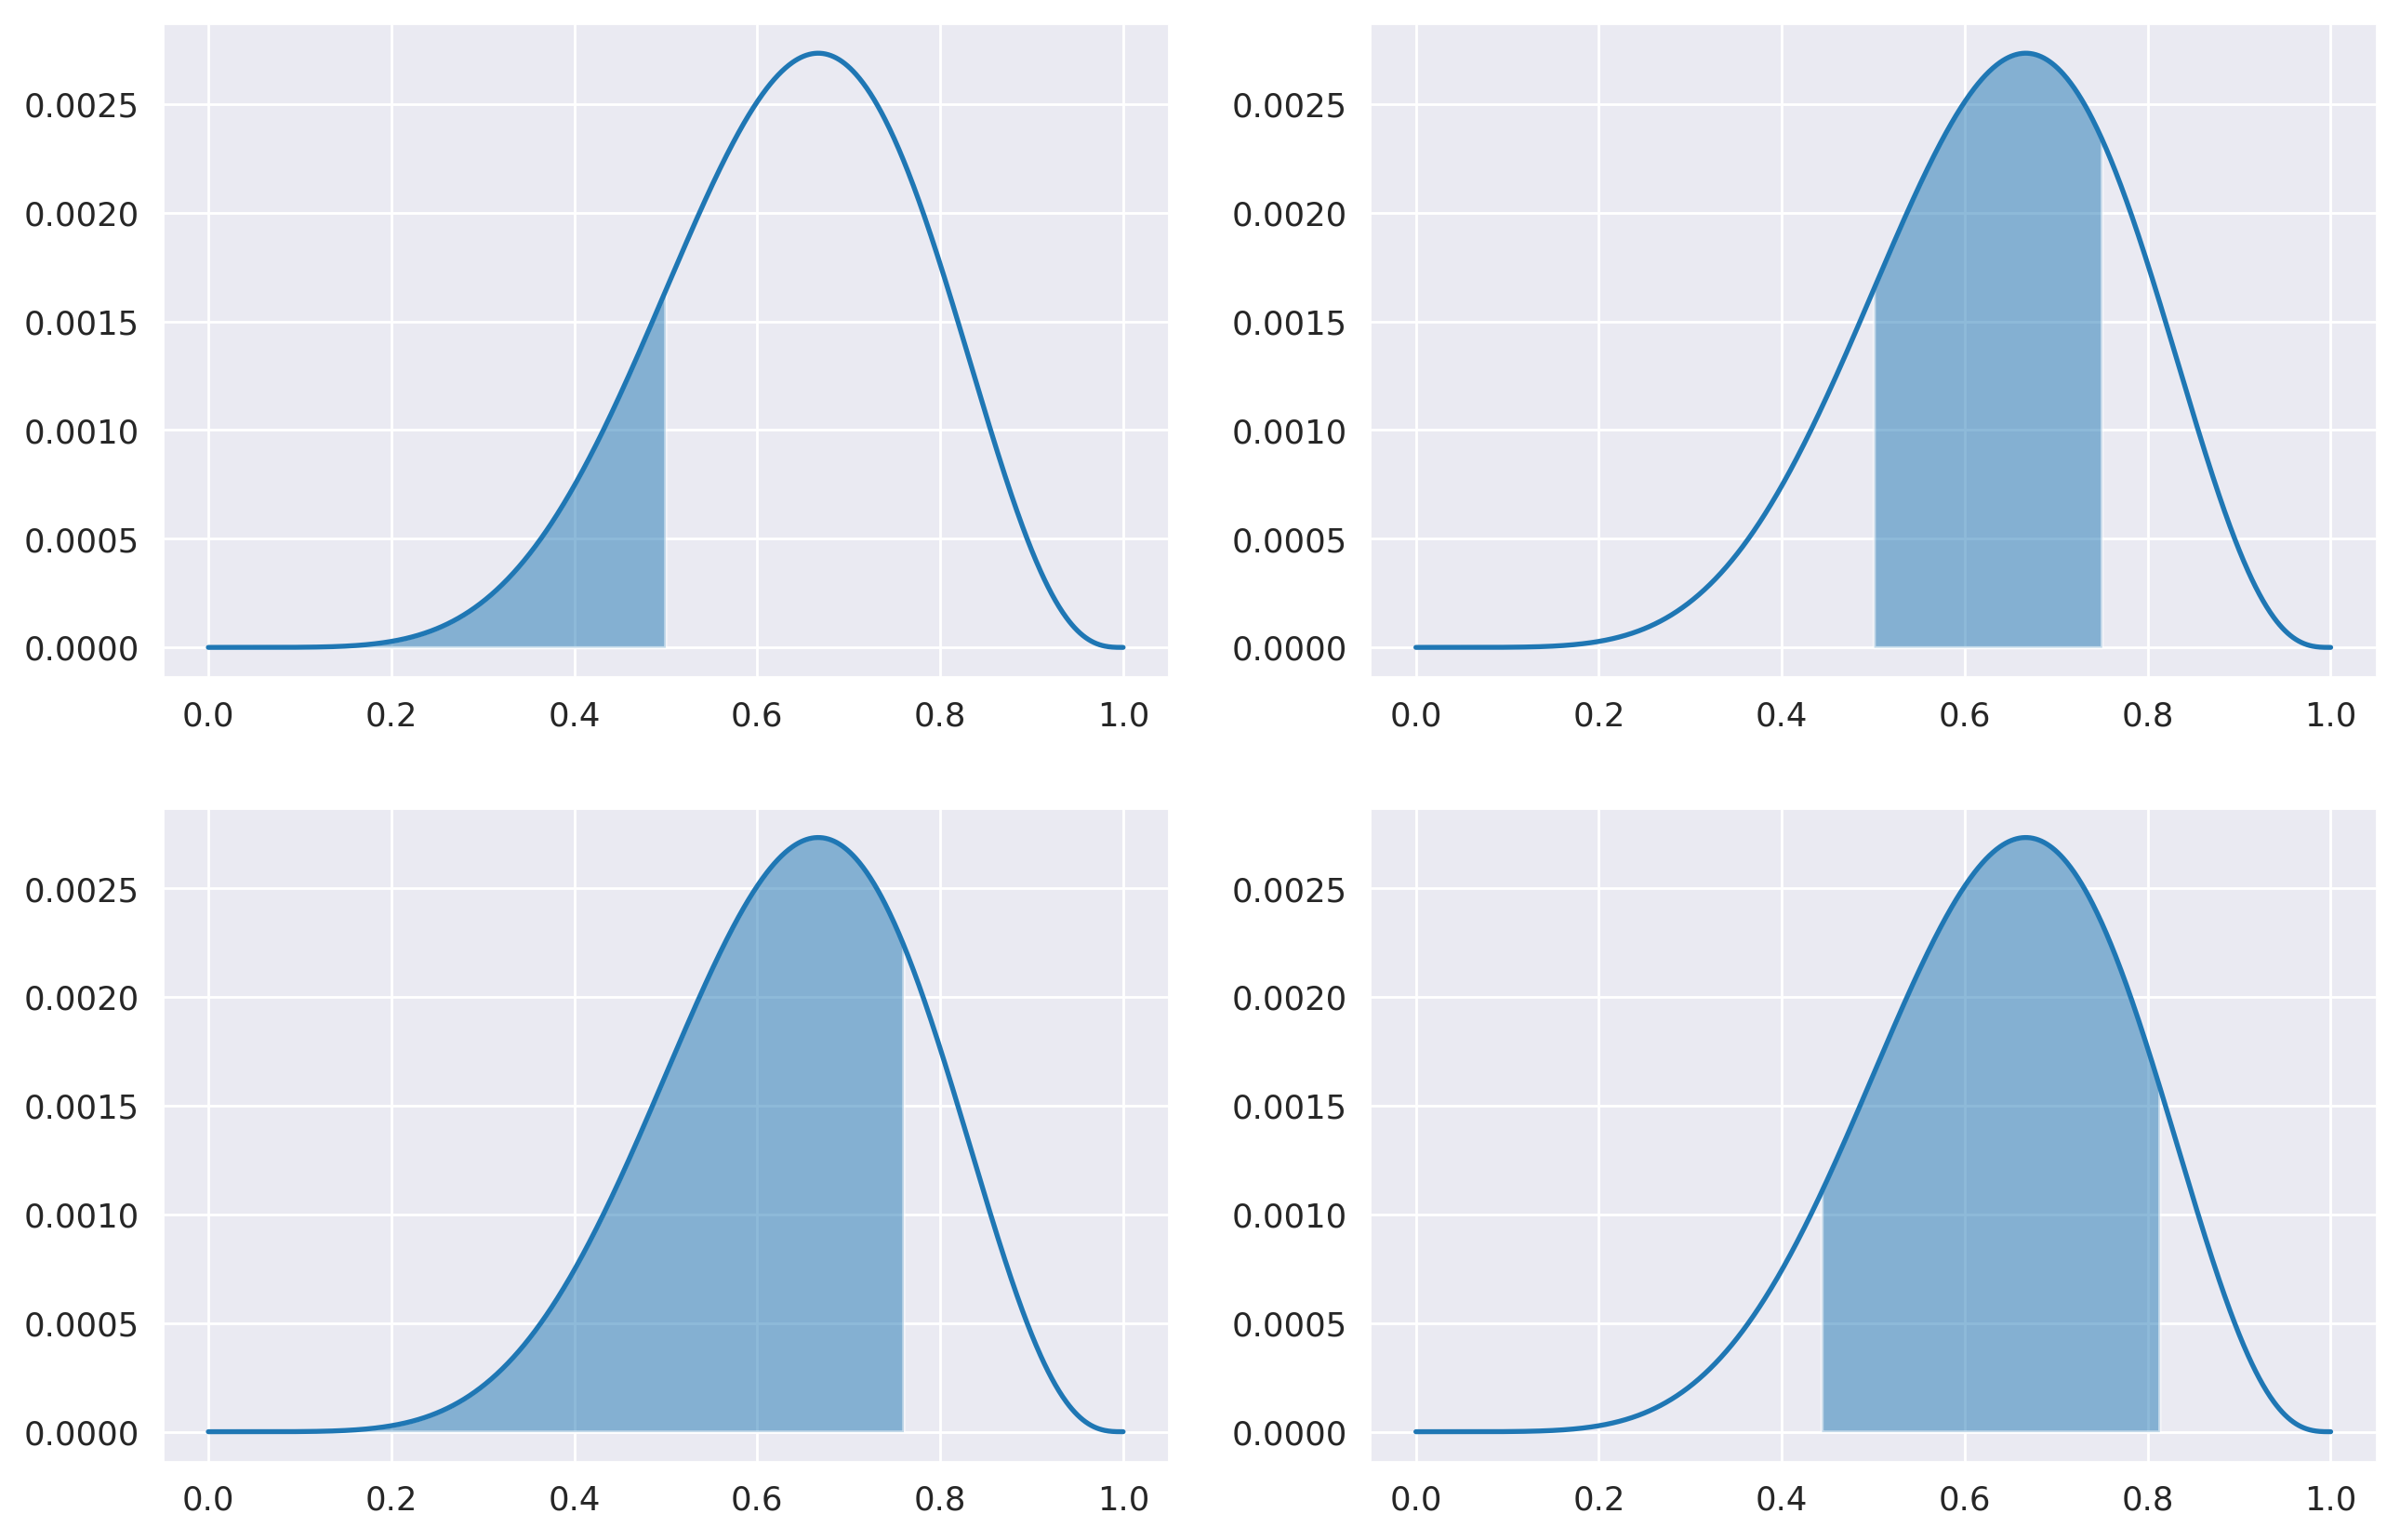

In [14]:
_plot_fn = partial(
    plot_posterior_interval, p_grid=p_grid, posterior=posterior
)

fig, axes = plt.subplots(2, 2, figsize=(12, 8), dpi=256)
((ax0, ax1), (ax2, ax3)) = axes

# TOP-LEFT
mask = (p_grid < 0.5)
_plot_fn(mask=mask, ax=ax0)

# TOP-RIGHT
mask = (p_grid > 0.5)
mask = mask & (p_grid < 0.75)
_plot_fn(mask=mask, ax=ax1)

# BOTTOM-LEFT
q = pd.Series(samples).quantile(0.8)
mask = (p_grid < q)
_plot_fn(mask=mask, ax=ax2)

# BOTTOM-RIGHT
q0, q1 = pd.Series(samples).quantile([0.1, 0.9])
mask = (p_grid > q0) & (p_grid < q1)
_plot_fn(mask=mask, ax=ax3);

# Code 3.11

In [15]:
sample = "WWW"
n = len(sample)
k = sample.count("W")

In [16]:
binom      = dist.Binomial(n=n, p=p_grid)
likelihood = jnp.exp(binom.logpdf(k))
posterior  = p_prior * likelihood
posterior /= posterior.sum()

In [17]:
samples   = jax.random.choice(
    a=p_grid, 
    p=posterior,
    shape=(100_000, ), 
    key=rng_key, 
)

In [18]:
pd.Series(samples).quantile([0.25, 0.75])

0.25    0.706707
0.75    0.930931
dtype: float64

# Figure 3.3 -- manually calcuated HPDI

In [19]:
def naive_hpdi(samples, size: float = 0.95):
    """ Brute-Force calculation of the Highest Posterior Density Interval 
    """
    
    s = np.array(samples)
    n = len(samples)
    indices  = np.argsort(s)
    s_sorted = np.sort(s)

    step = int(size * n)
    best = float("inf")
    i, j = None, None
    
    for idx in range(n - step):
        d = s_sorted[idx + step] - s_sorted[idx]
        if d < best:
            best = d
            i, j = idx, idx + step
        
    low = s_sorted[i]
    high = s_sorted[j]
    
    return low, high
        

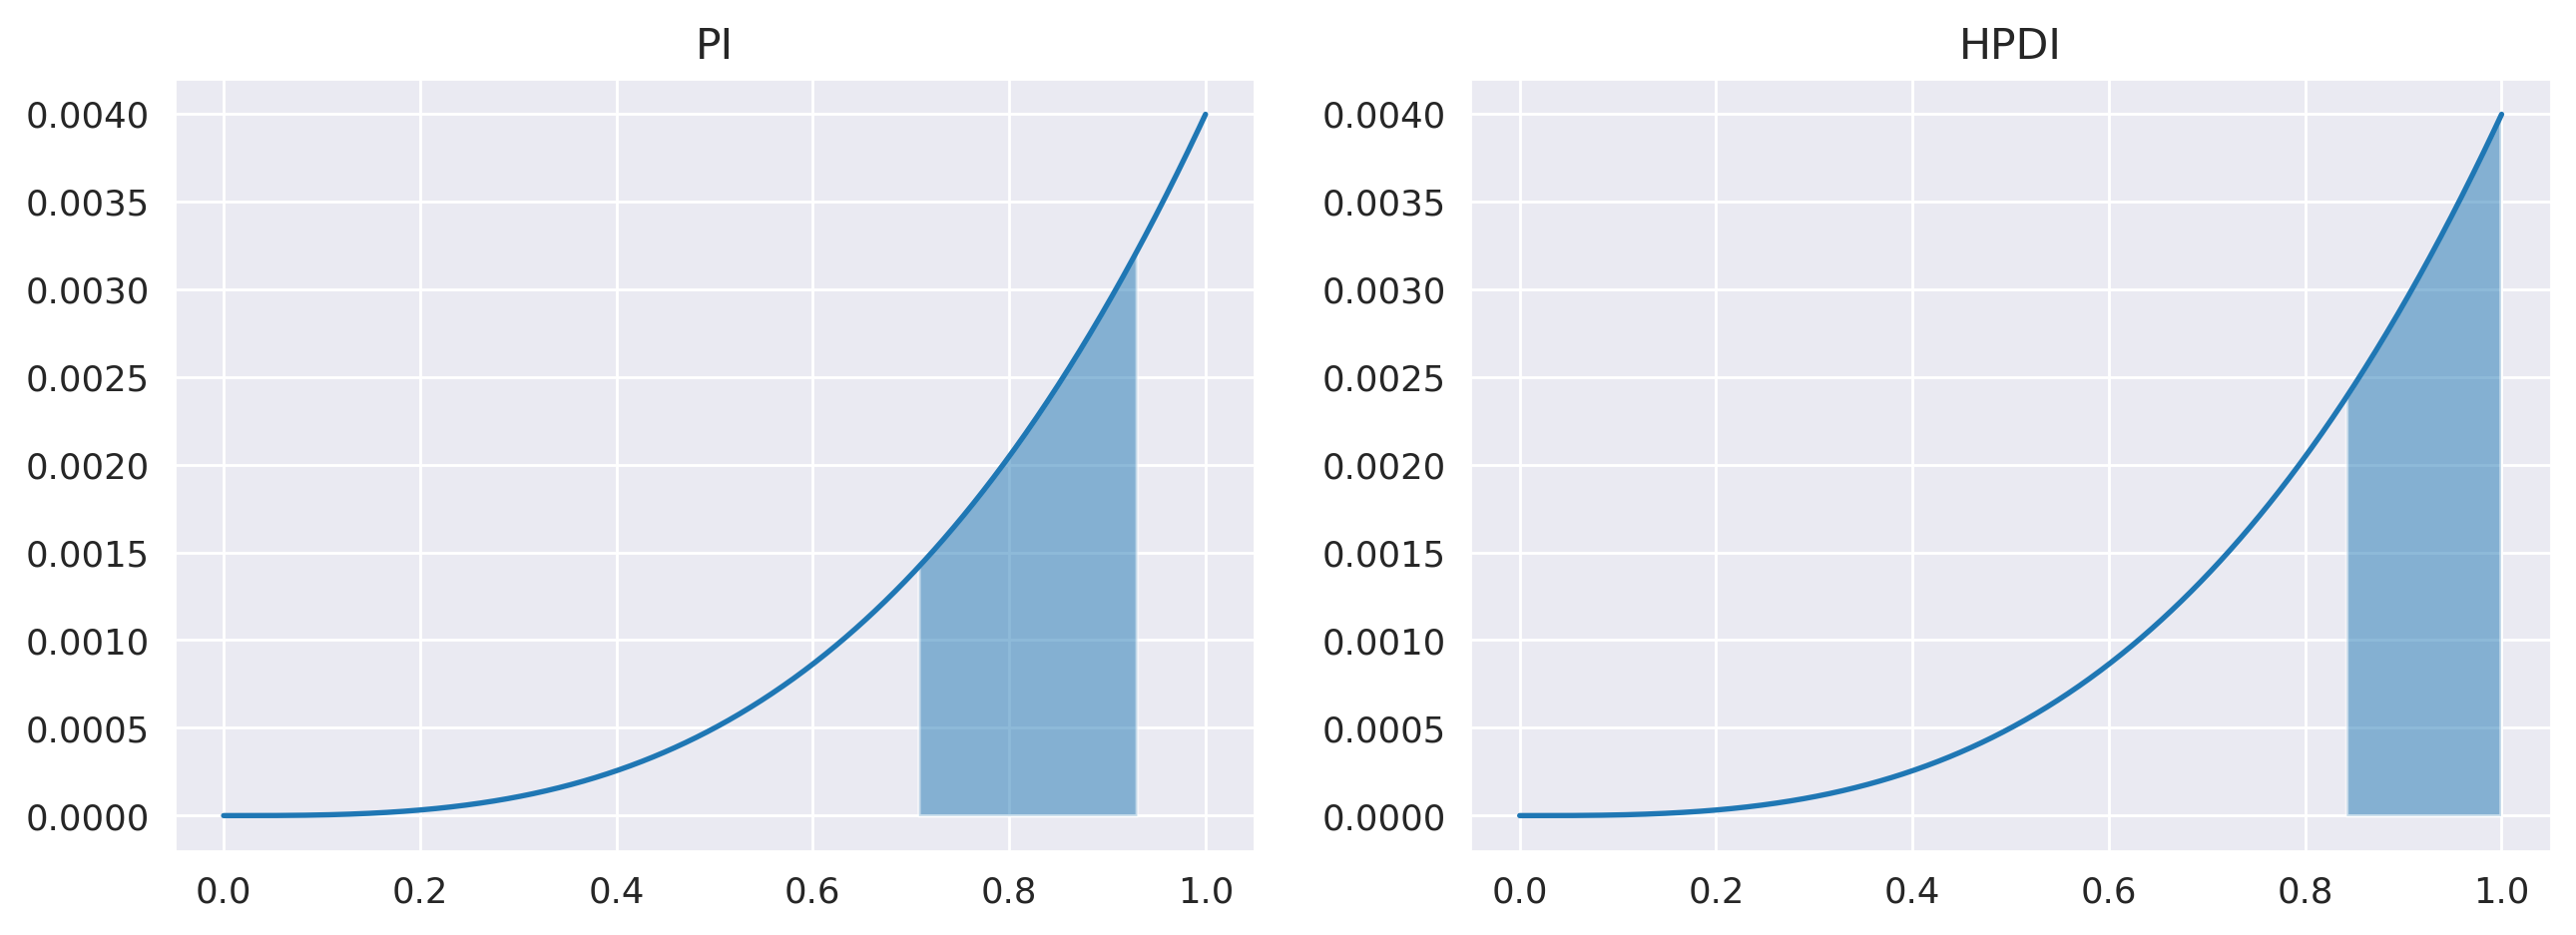

In [20]:
_plot_fn = partial(
    plot_posterior_interval, p_grid=p_grid, posterior=posterior
)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4), dpi=256)

# PI
low, high = pd.Series(samples).quantile([0.25, 0.75])
mask = (p_grid > low) & (p_grid < high)
ax0 = _plot_fn(mask=mask, ax=ax0)
_ = ax0.set_title("PI")

# HPDI
low, high = naive_hpdi(samples, 0.5)
mask = (p_grid > low) & (p_grid < high)
ax0 = _plot_fn(mask=mask, ax=ax1)
_ = ax1.set_title("HPDI")

`TODO`: is there a way to create similar plots with `arviz`?

# Code 3.12

In [21]:
pd.Series(samples).quantile([0.25, 0.75])

0.25    0.706707
0.75    0.930931
dtype: float64

# Code 3.13

In [22]:
naive_hpdi(samples, 0.5)

(0.8408408, 1.0)

# Code 3.14

In [23]:
mode = float(
    p_grid[jnp.argmax(posterior)]
)

mode

1.0

# Code 3.15

In [24]:
kde = sts.gaussian_kde(samples, bw_method=0.01)
density = kde.evaluate(p_grid)

p_grid[np.argmax(density)]

DeviceArray(0.995996, dtype=float32)

# Code 3.15

In [25]:
mean = float(
    jnp.mean(samples)
)

mean

0.7996633052825928

In [26]:
median = float(
    jnp.median(samples)
)

median

0.8408408164978027

# Figure 3.5 Left

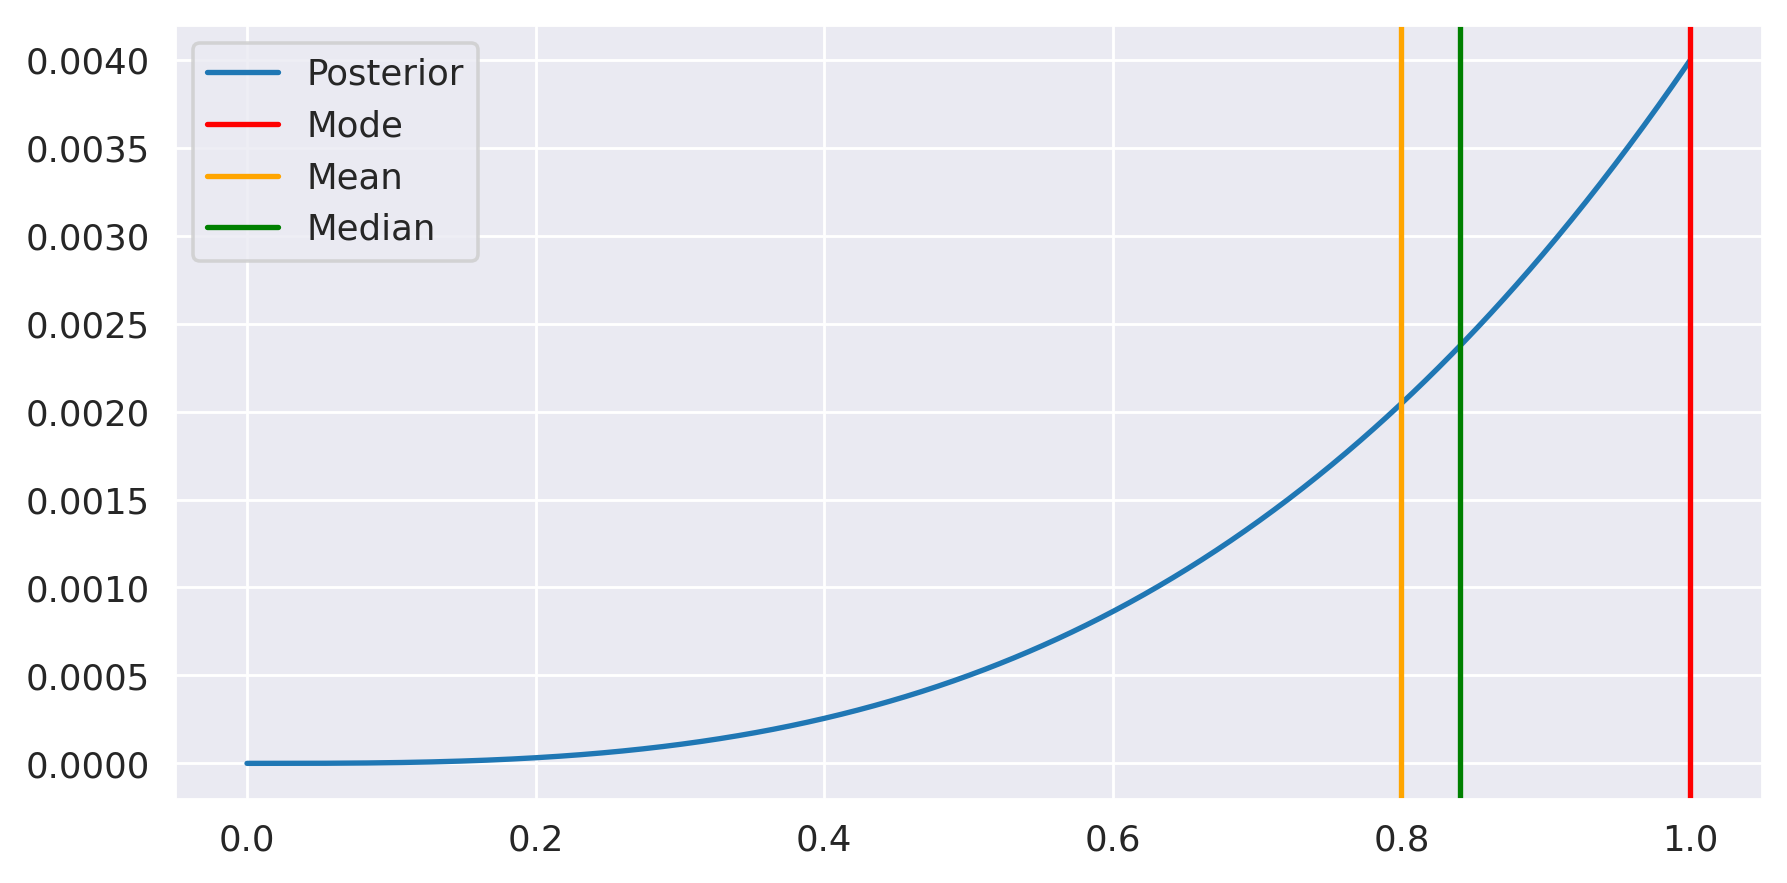

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), dpi=256)

ax = sns.lineplot(x=p_grid, y=posterior)
ax.axvline(mode, color="red")
ax.axvline(mean, color="orange")
ax.axvline(median, color="green")

ax.legend(["Posterior", "Mode", "Mean", "Median"])